In [ ]:
#!pip install scanpy
#!pip install pybiomart
#!pip install scrublet
#!pip3 install leidenalg
#!pip install harmonypy

## Bring In Sample Data

This notebook is written based on a set of Bone Marrow Cell Data downloaded from Terra.

To copy the data from the Google Cloud, add the Google SDK toolkit to your bash.

In [ ]:
#!gsutil -m cp -r gs://terra-featured-workspaces/Cumulus/cellranger_output ./demodata

In [ ]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from warnings import simplefilter
simplefilter("ignore", UserWarning)
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter("ignore", FutureWarning)

sc.settings.verbosity = 1
sc.settings.figdir = 'figures'
h5 = './demodata/cellranger_output/'

sc.settings.set_figure_params(dpi=100, fontsize=10, dpi_save=200,
    facecolor = 'white', figsize=(6,6), format='png')

In [124]:
import os

def make_dirs(file):
    try:
       os.makedirs(file)
    except FileExistsError:
       # directory already exists
       pass
    return

make_dirs("figures")
make_dirs("figures/umapfigures")
make_dirs("results")




In [132]:
# importing module
from pandas import *
 
# reading CSV file
data = read_csv("sample_sheet.csv")
data

Sample                                           Filepath
0  MantonBM1  demodata/cellranger_output/MantonBM1_HiSeq_1/r...
1  MantonBM2  demodata/cellranger_output/MantonBM2_HiSeq_1/r...
2  MantonBM3  demodata/cellranger_output/MantonBM3_HiSeq_1/r...
3  MantonBM4  demodata/cellranger_output/MantonBM4_HiSeq_1/r...
4  MantonBM5  demodata/cellranger_output/MantonBM5_HiSeq_1/r...
5  MantonBM6  demodata/cellranger_output/MantonBM6_HiSeq_1/r...
6  MantonBM7  demodata/cellranger_output/MantonBM7_HiSeq_1/r...
7  MantonBM8  demodata/cellranger_output/MantonBM8_HiSeq_1/r...

In [133]:
#samplenames = sorted(os.listdir(h5))

samplenames = data['Sample']
samplenames


0    MantonBM1
1    MantonBM2
2    MantonBM3
3    MantonBM4
4    MantonBM5
5    MantonBM6
6    MantonBM7
7    MantonBM8
Name: Sample, dtype: object

In [135]:
#filelist = [h5 + s + '/raw_feature_bc_matrix.h5' for s in samplenames]
#len(filelist)

filelist=data['Filepath']

filelist

0    demodata/cellranger_output/MantonBM1_HiSeq_1/r...
1    demodata/cellranger_output/MantonBM2_HiSeq_1/r...
2    demodata/cellranger_output/MantonBM3_HiSeq_1/r...
3    demodata/cellranger_output/MantonBM4_HiSeq_1/r...
4    demodata/cellranger_output/MantonBM5_HiSeq_1/r...
5    demodata/cellranger_output/MantonBM6_HiSeq_1/r...
6    demodata/cellranger_output/MantonBM7_HiSeq_1/r...
7    demodata/cellranger_output/MantonBM8_HiSeq_1/r...
Name: Filepath, dtype: object

In [136]:
def read_h5(file):
    if file.endswith('.h5') :
       print (f'Reading in {file}')
    else:
        raise ValueError(f'Unsupported filetype: {file}')
    return 
              
for i in range (len(filelist)):
    read_h5(filelist[i])


Reading in demodata/cellranger_output/MantonBM1_HiSeq_1/raw_feature_bc_matrix.h5
Reading in demodata/cellranger_output/MantonBM2_HiSeq_1/raw_feature_bc_matrix.h5
Reading in demodata/cellranger_output/MantonBM3_HiSeq_1/raw_feature_bc_matrix.h5
Reading in demodata/cellranger_output/MantonBM4_HiSeq_1/raw_feature_bc_matrix.h5
Reading in demodata/cellranger_output/MantonBM5_HiSeq_1/raw_feature_bc_matrix.h5
Reading in demodata/cellranger_output/MantonBM6_HiSeq_1/raw_feature_bc_matrix.h5
Reading in demodata/cellranger_output/MantonBM7_HiSeq_1/raw_feature_bc_matrix.h5
Reading in demodata/cellranger_output/MantonBM8_HiSeq_1/raw_feature_bc_matrix.h5


In [137]:
#metadata_type = ['Female','Male','Male','Male','Male','Female','Female','Female']
#samplebrief = [i.split('_', 1)[0] for i in samplenames]
#metadata_sample = [i + '_' + j for i, j in zip(samplebrief, metadata_type)]

adatas = [] 
for i in range(len(samplenames)):
#    meta = metadata_type[i]
#    label = metadata_sample[i]
    label = samplenames[i]
    filename = filelist[i]
    adata = sc.read_10x_h5(filename)
    adata.var_names_make_unique()
#    adata.obs['type'] = meta
    adata.obs['sample'] = label
    adatas.append(adata) 

adata = adatas[0].concatenate(adatas[1:])

print(f"Anndata matrix for all batches contains {adata.shape[0]} obs and {adata.shape[1]} var")

Anndata matrix for all batches contains 2413744 obs and 36601 var


## Print the Number of Observations Per Sample

In [138]:
print ("Number of observations per sample")
print(adata.obs['sample'].value_counts())

#adata

Number of observations per sample
MantonBM5    340364
MantonBM6    323253
MantonBM8    308058
MantonBM7    307232
MantonBM1    302618
MantonBM2    281141
MantonBM4    280951
MantonBM3    270127
Name: sample, dtype: int64


## Filter Cells and Genes

* Remove Cells that have Have Gene Expression levels below 500 and above 6000
* Remove Genes that are in less thatn 5% of the Cells



In [ ]:
#Initial quality control
min_genes = 200
min_cells = 3

sc.pp.filter_cells(adata, min_genes=min_genes)
sc.pp.filter_genes(adata, min_cells=min_cells)

print("Initial QC")
print(f"Filtering cells that express less than {min_genes} and genes expressed in less than {min_cells} cells")
print(f"Anndata matrix for all batches contains {adata.shape[0]} obs and {adata.shape[1]} var")

In [ ]:
#sc.pp.filter_cells(adata, min_genes=200)
#sc.pp.filter_genes(adata, min_cells=3)
#s = pd.Series(adata.var['n_cells_by_counts'])

#ax = s.plot.kde()
#ax.set_xlim(0, 100000)

In [148]:
#calculate qc metrics, add qc metric for whether gene is mitochondrial
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
#adata.var

gene_ids    feature_types  genome     mt  \
MIR1302-2HG  ENSG00000243485  Gene Expression  GRCh38  False   
FAM138A      ENSG00000237613  Gene Expression  GRCh38  False   
OR4F5        ENSG00000186092  Gene Expression  GRCh38  False   
AL627309.1   ENSG00000238009  Gene Expression  GRCh38  False   
AL627309.3   ENSG00000239945  Gene Expression  GRCh38  False   
...                      ...              ...     ...    ...   
AC141272.1   ENSG00000277836  Gene Expression  GRCh38  False   
AC023491.2   ENSG00000278633  Gene Expression  GRCh38  False   
AC007325.1   ENSG00000276017  Gene Expression  GRCh38  False   
AC007325.4   ENSG00000278817  Gene Expression  GRCh38  False   
AC007325.2   ENSG00000277196  Gene Expression  GRCh38  False   

             n_cells_by_counts  mean_counts  pct_dropout_by_counts  \
MIR1302-2HG                  3     0.000071              99.992857   
FAM138A                      0     0.000000             100.000000   
OR4F5                        0     0.000000             100.000000   
AL627309.1                  35     0.000833              99.916665   
AL627309.3                   0     0.000000             100.000000   
...                        ...          ...                    ...   
AC141272.1                   1     0.000024              99.997619   
AC023491.2                   0     0.000000             100.000000   
AC007325.1                   0     0.000000             100.000000   
AC007325.4                 460     0.011500              98.904736   
AC007325.2                   1     0.000024              99.997619   

             total_counts  
MIR1302-2HG           3.0  
FAM138A               0.0  
OR4F5                 0.0  
AL627309.1           35.0  
AL627309.3            0.0  
...                   ...  
AC141272.1            1.0  
AC023491.2            0.0  
AC007325.1            0.0  
AC007325.4          483.0  
AC007325.2            1.0  

[36601 rows x 8 columns]

## Filter Cells with Between a Minimum and Maximum Number of Genes Expressed

In [143]:
#Filter cells with
#number of genes expressed >500
#number of genes expressed < 6000

min_genes= 500
max_genes = 6000

sc.pp.filter_cells(adata, min_genes=min_genes)
sc.pp.filter_cells(adata, max_genes=max_genes)

print (f"After filtering for genes expressed greater than {min_genes} and less than {max_genes}") 
#print(adata.obs['sample'].value_counts())
print(f"Anndata matrix for all batches contains {adata.shape[0]} obs and {adata.shape[1]} var")

After filtering for genes expressed greater than 500 and less than 6000
Anndata matrix for all batches contains 42682 obs and 36601 var


## Filter Cells with High Mitochondrial Gene Expression


In [144]:
max_mito=10

mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

adata = adata[(adata.obs['pct_counts_mt'] < max_mito), :]

#print(adata.obs['sample'].value_counts())

print (f"After filtering for cells with more than {max_mito}% mitochondrial gene expression")
print(f"Anndata matrix for all batches contains {adata.shape[0]} obs and {adata.shape[1]} var")

After filtering for cells with more than 10% mitochondrial gene expression
Anndata matrix for all batches contains 41999 obs and 36601 var


## Filter out genes expressed in less than 5% of the cells

In [149]:
#The number of genes that are found in less than 5% of the cells are removed
min_percent=0.05

adata = adata[:, adata.var['n_cells_by_counts'] > adata.var['n_cells_by_counts'].max()*min_percent]

#print(adata.obs['sample'].value_counts())

print (f"After filtering for genes expressed in less than {min_percent*100}% of cells")
print(f"Anndata matrix for all batches contains {adata.shape[0]} obs and {adata.shape[1]} var")


After filtering for genes expressed in less than 5.0% of cells
Anndata matrix for all batches contains 41999 obs and 7074 var


In [ ]:
#print(adata.var.value_counts())

## Filter out Technical Artifacts

In [151]:
malat1 = adata.var_names.str.startswith('MALAT1')
# we need to redefine the mito_genes since they were first 
# calculated on the full object before removing low expressed genes.
mito_genes = adata.var_names.str.startswith('MT-')
remove = np.add(mito_genes, malat1)
keep = np.invert(remove)

adata = adata[:,keep]
print (f"After filtering for technical artifacts")
print(f"Anndata matrix for all batches contains {adata.shape[0]} obs and {adata.shape[1]} var")


After filtering for technical artifacts
Anndata matrix for all batches contains 41999 obs and 7060 var


In [ ]:
#sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
  #           jitter=0.4, groupby = 'sample', rotation = 45)

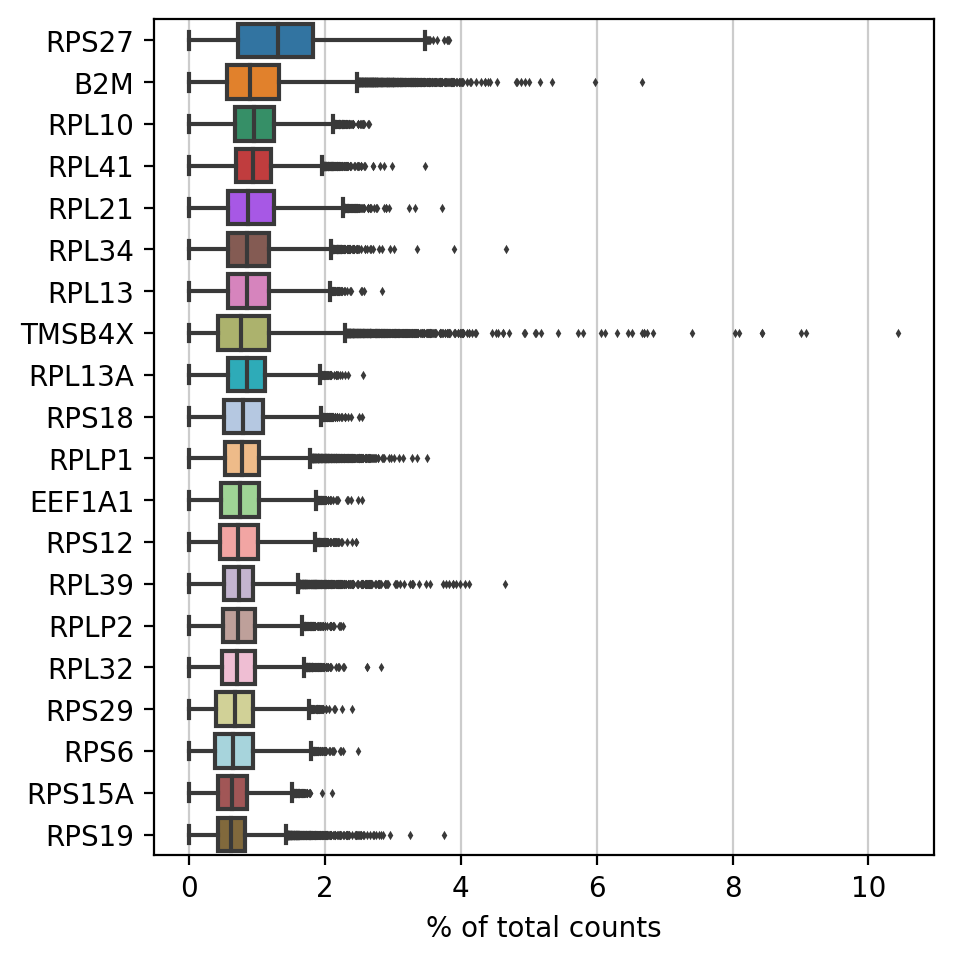

In [152]:
sc.pl.highest_expr_genes(adata, n_top=20)

## This section is optional 

This section looks at chrY markers and determines the likelihood of the gender of the sample origin.

This is the source of the metadata at the top of the notebook.

In [153]:
annot = sc.queries.biomart_annotations(
        "hsapiens",
        ["ensembl_gene_id", "external_gene_name", "start_position", "end_position", "chromosome_name"],
    ).set_index("external_gene_name")
#>>> adata.var[annot.columns] = annot

In [154]:
chrY_genes = adata.var_names.intersection(annot.index[annot.chromosome_name == "Y"])
chrY_genes

Index(['RPS4Y1', 'PRKY', 'USP9Y', 'DDX3Y', 'UTY', 'TTTY14', 'EIF1AY'], dtype='object')

In [155]:
adata.obs['percent_chrY'] = np.sum(
    adata[:, chrY_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1 * 100

In [156]:
# color inputs must be from either .obs or .var, so add in XIST expression to obs.
adata.obs["XIST-counts"] = adata.X[:,adata.var_names.str.match('XIST')].toarray()

#sc.pl.scatter(adata, x='XIST-counts', y='percent_chrY', color="sample")

In [157]:
for i in range(len(filelist)):

    MeanChrY = adata[adata.obs['batch'] == str(i) , :].obs['percent_chrY'].mean()
    print(adata.obs['sample'][0])
    print(f"Calculated Percentage of ChrY Genes {MeanChrY:.2E}")
    if MeanChrY > 0.05:
        sex = 'M'        
    else:
        sex = 'F'
        
    print(f"Assigned sex: {sex}")
    
    

    batchname = adata[adata.obs['batch'] == str(i) , :].obs_names
    adata.obs.loc[batchname, 'sex'] = sex



MantonBM1
Calculated Percentage of ChrY Genes 1.37E-04
Assigned sex: F
MantonBM1
Calculated Percentage of ChrY Genes 1.32E-01
Assigned sex: M
MantonBM1
Calculated Percentage of ChrY Genes 1.25E-01
Assigned sex: M
MantonBM1
Calculated Percentage of ChrY Genes 1.15E-01
Assigned sex: M
MantonBM1
Calculated Percentage of ChrY Genes 1.21E-01
Assigned sex: M
MantonBM1
Calculated Percentage of ChrY Genes 1.11E-04
Assigned sex: F
MantonBM1
Calculated Percentage of ChrY Genes 8.53E-05
Assigned sex: F
MantonBM1
Calculated Percentage of ChrY Genes 1.52E-04
Assigned sex: F


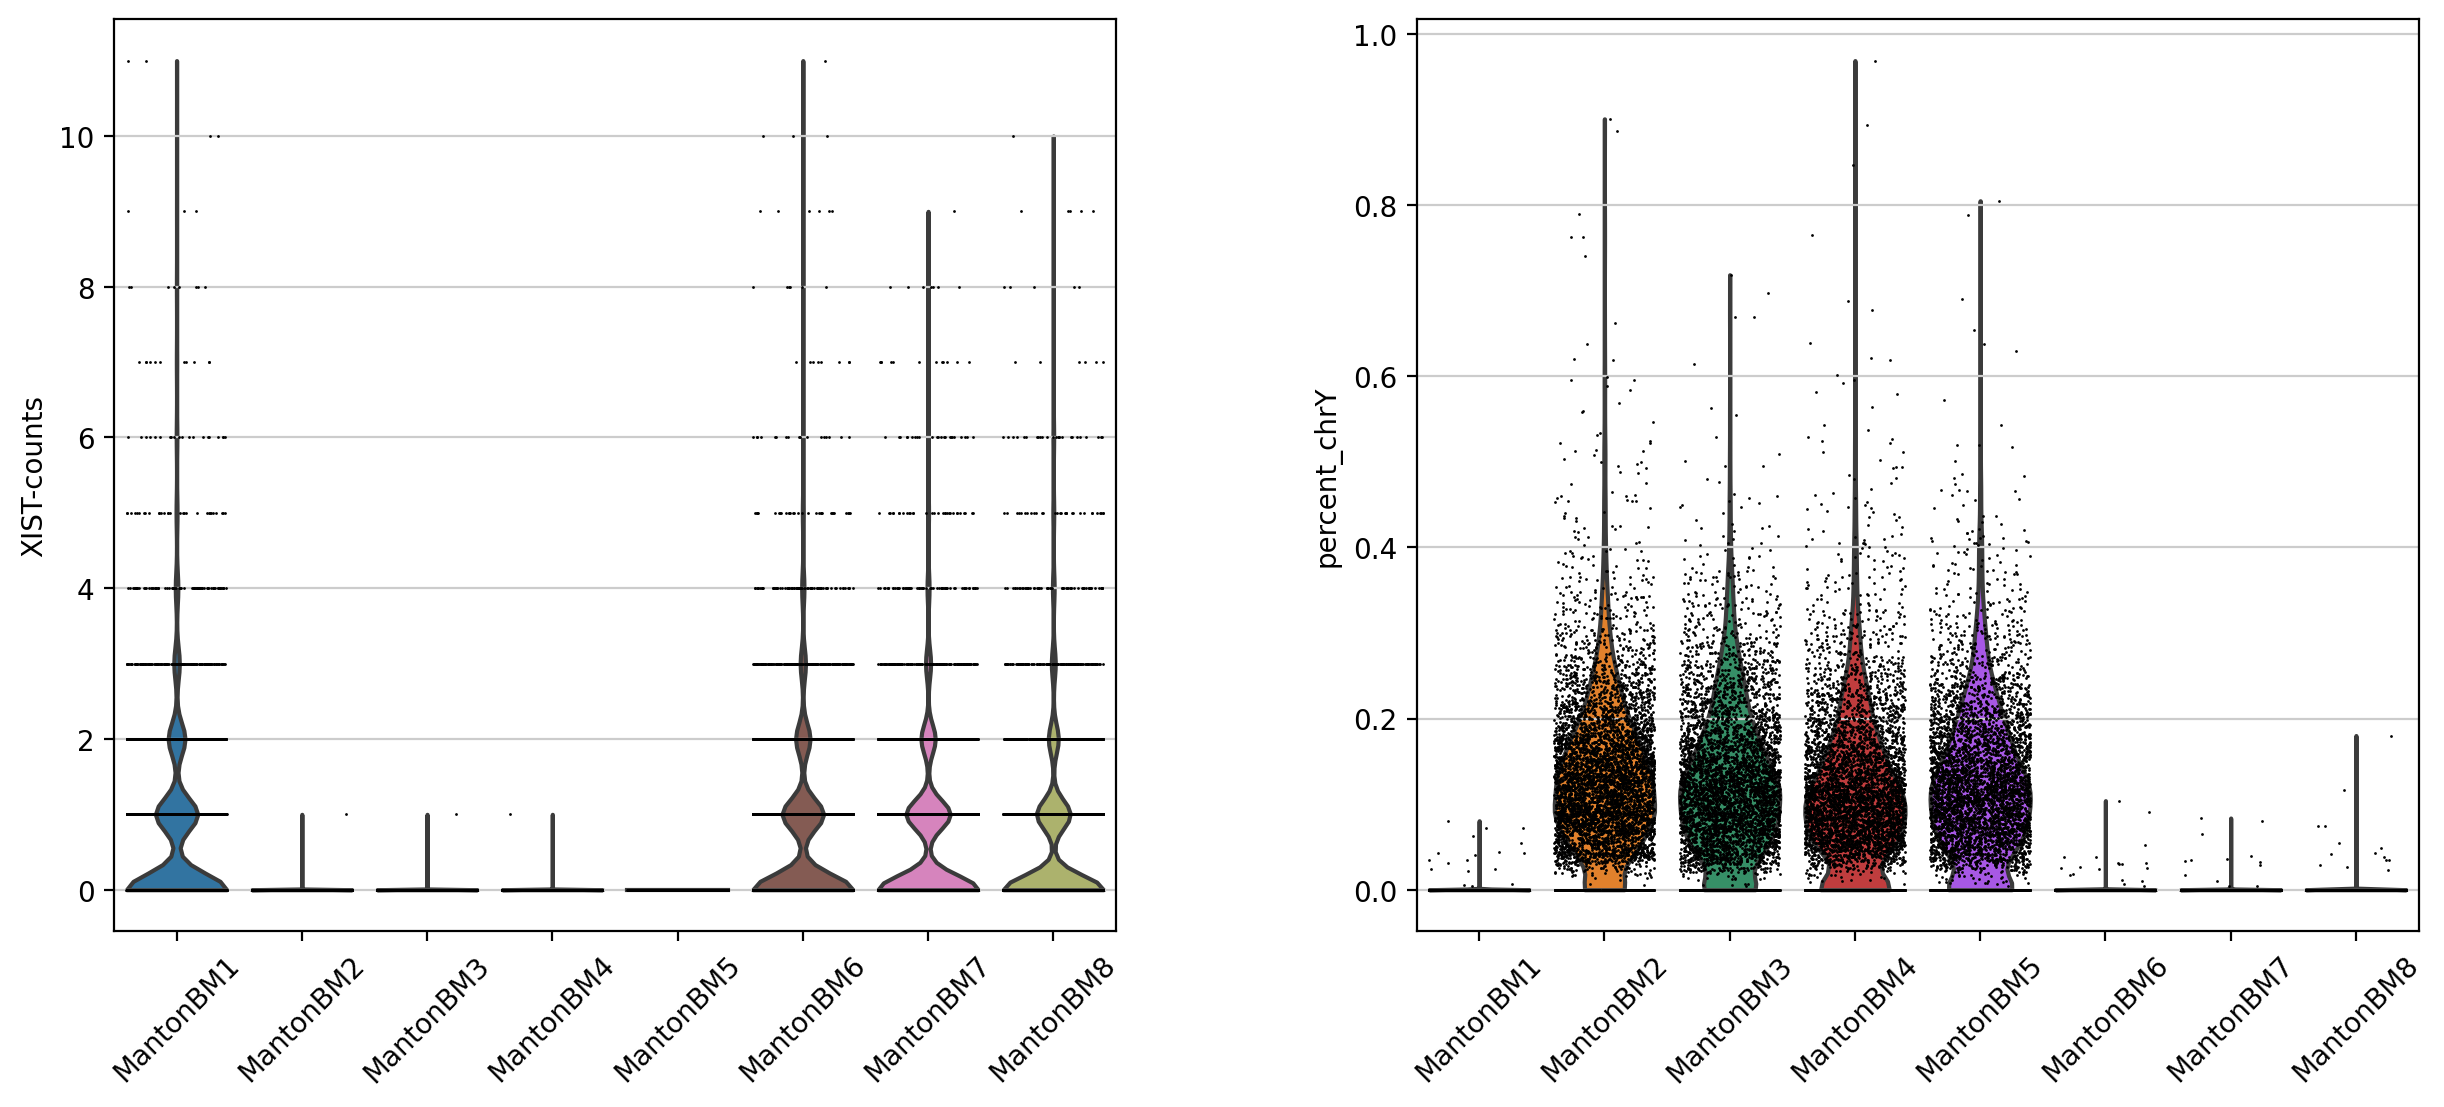

In [158]:



sc.pl.violin(adata, ["XIST-counts", "percent_chrY"], jitter=0.4, groupby = 'sample', rotation= 45,show=False)

plt.savefig("demodata/gender_counts_violin.pdf")




## Extract Highly Expressed Genes

### Log Normalize Data by 100,000 Reads Per Cell

In [159]:
sc.pp.filter_genes(adata, min_cells=1)
sc.pp.normalize_total(adata, target_sum=1e5)
sc.pp.log1p(adata)

print("Log Normalize Data by 100,000 Reads Per Cell")
#print(adata.n_obs, adata.n_vars)

41999 7060


### Optional Demo on Doublets

In [ ]:
#import scrublet as scr

# split per batch into new objects.
#batches = adata.obs['sample'].cat.categories.tolist()
#alldata = {}
#for batch in batches:
#    tmp = adata[adata.obs['sample'] == batch,]
#    print(batch, ":", tmp.shape[0], " cells")
#    scrub = scr.Scrublet(tmp.raw.X)
#    out = scrub.scrub_doublets(verbose=False, n_prin_comps = 20)
#    alldata[batch] = pd.DataFrame({'doublet_score':out[0],'predicted_doublets':out[1]},index = tmp.obs.index)
#    print(alldata[batch].predicted_doublets.sum(), " predicted_doublets")

In [ ]:
# add predictions to the adata object.
#scrub_pred = pd.concat(alldata.values())
#adata.obs['doublet_scores'] = scrub_pred['doublet_score'] 
#adata.obs['predicted_doublets'] = scrub_pred['predicted_doublets'] 

#sum(adata.obs['predicted_doublets'])

In [ ]:
# add in column with singlet/doublet instead of True/Fals
#%matplotlib inline

#adata.obs['doublet_info'] = adata.obs["predicted_doublets"].astype(str)

#sc.pl.violin(adata, 'n_genes_by_counts',
#             jitter=0.4, groupby = 'doublet_info', rotation=45)

In [ ]:
#sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
#sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

## Extract Highly Variable Genes

In [163]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]

print("Extract Highly Variable Genes")
print(adata.var.highly_variable.head())




Extract Highly Variable Genes
LINC01409    True
ISG15        True
NADK         True
SKI          True
UBE4B        True
Name: highly_variable, dtype: bool


In [ ]:
#sc.pl.highly_variable_genes(adata)

In [ ]:
print("Regress Highly Variable Genes")

sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])


In [164]:
max_value=10

print(f"Scale Matrix at {max_value}")

sc.pp.scale(adata, max_value=max_value)

Scale Matrix at 10


## Run PCA

Run PCA with number of pcs 50


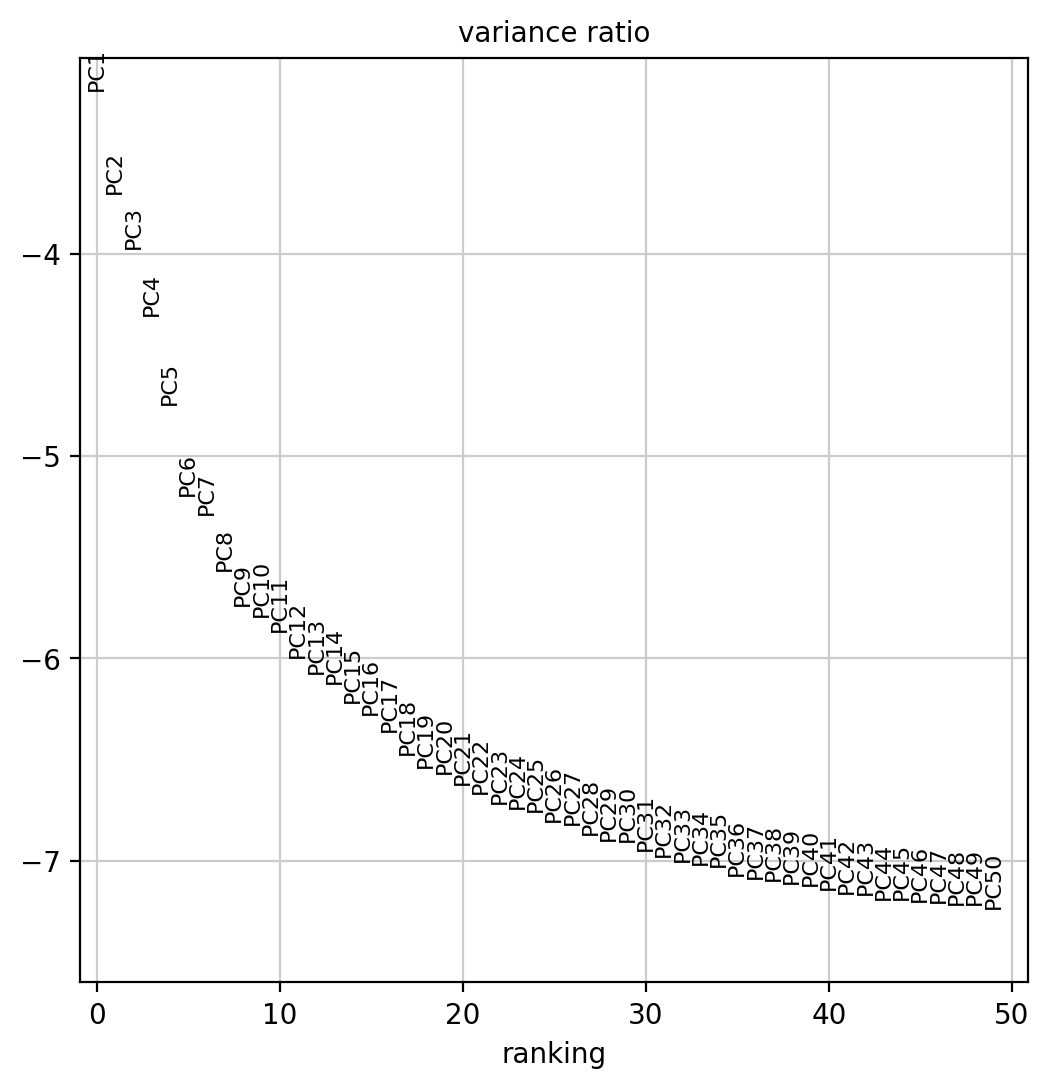

In [166]:
n_pcs=50

print(f"Run PCA with number of pcs {n_pcs}")

sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True, show=False, n_pcs=n_pcs, save='') # scanpy generates the filename automatically

## Run Nearest Neighbor Analysis

In [167]:
n_pcs=50

print(f"Run Nearest Neighbor with number of pcs {n_pcs}")

sc.pp.neighbors(adata, n_neighbors=100, n_pcs=n_pcs)

Run Nearest Neighbor with number of pcs 50


## Run UMAP Data

In [170]:
print("Generating UMAP")
sc.tl.umap(adata)

Generating UMAP


## Run Leiden Analysis

In [171]:
resolution = 1.3

print(f"Run Leiden Analysis with resolution {resolution}")

sc.tl.leiden(adata,resolution=resolution)

Run Leiden Analysis with resolution 1.3


In [172]:
leidennum = len(set(adata.obs.leiden))
print(f"Leiden analysis generated {leidennum} clusters")

Leiden analysis generated 23 clusters


## Test Color by Leiden on UMAP

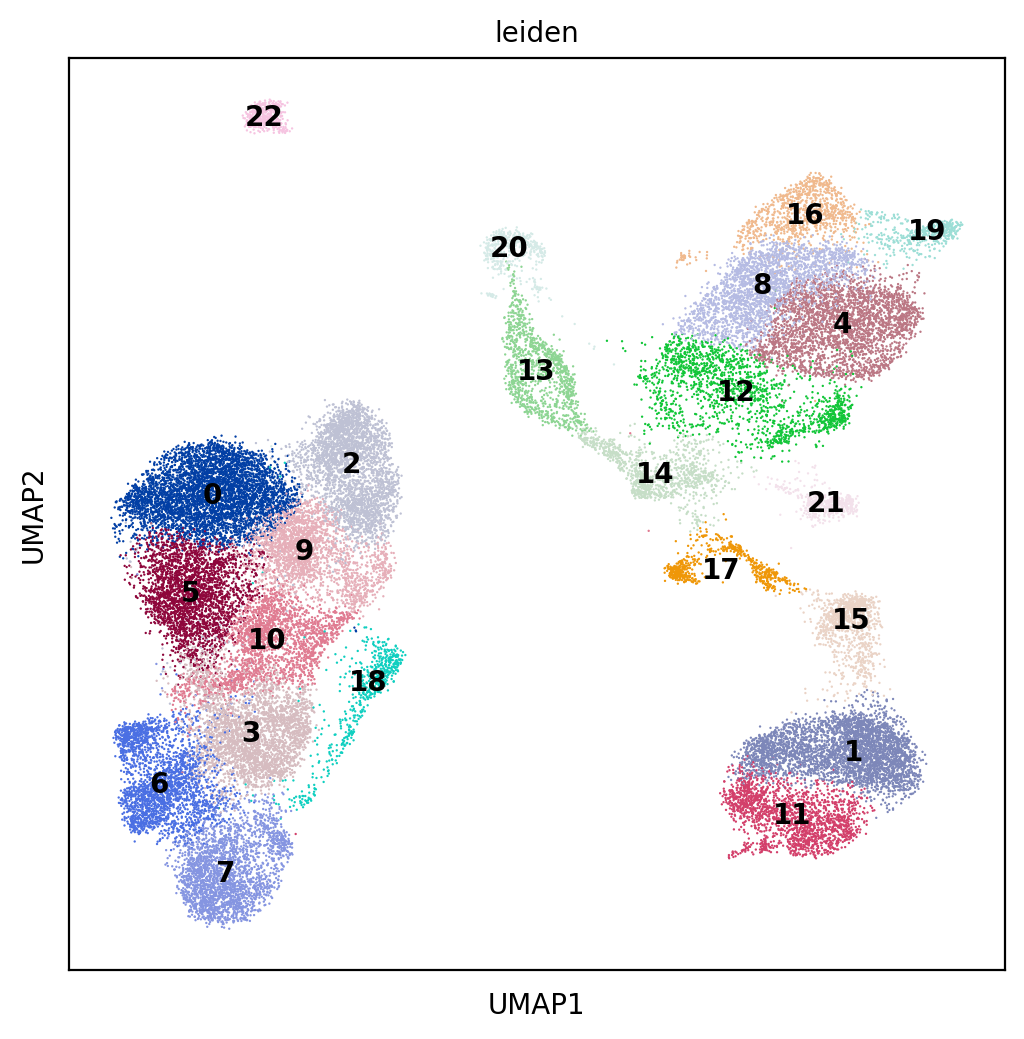

In [173]:
sc.pl.umap(adata, color=['leiden'],legend_loc='on data')

## Find marker genes for each leiden cluster using Mann-Whitney-U test

/opt/conda/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:421: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]


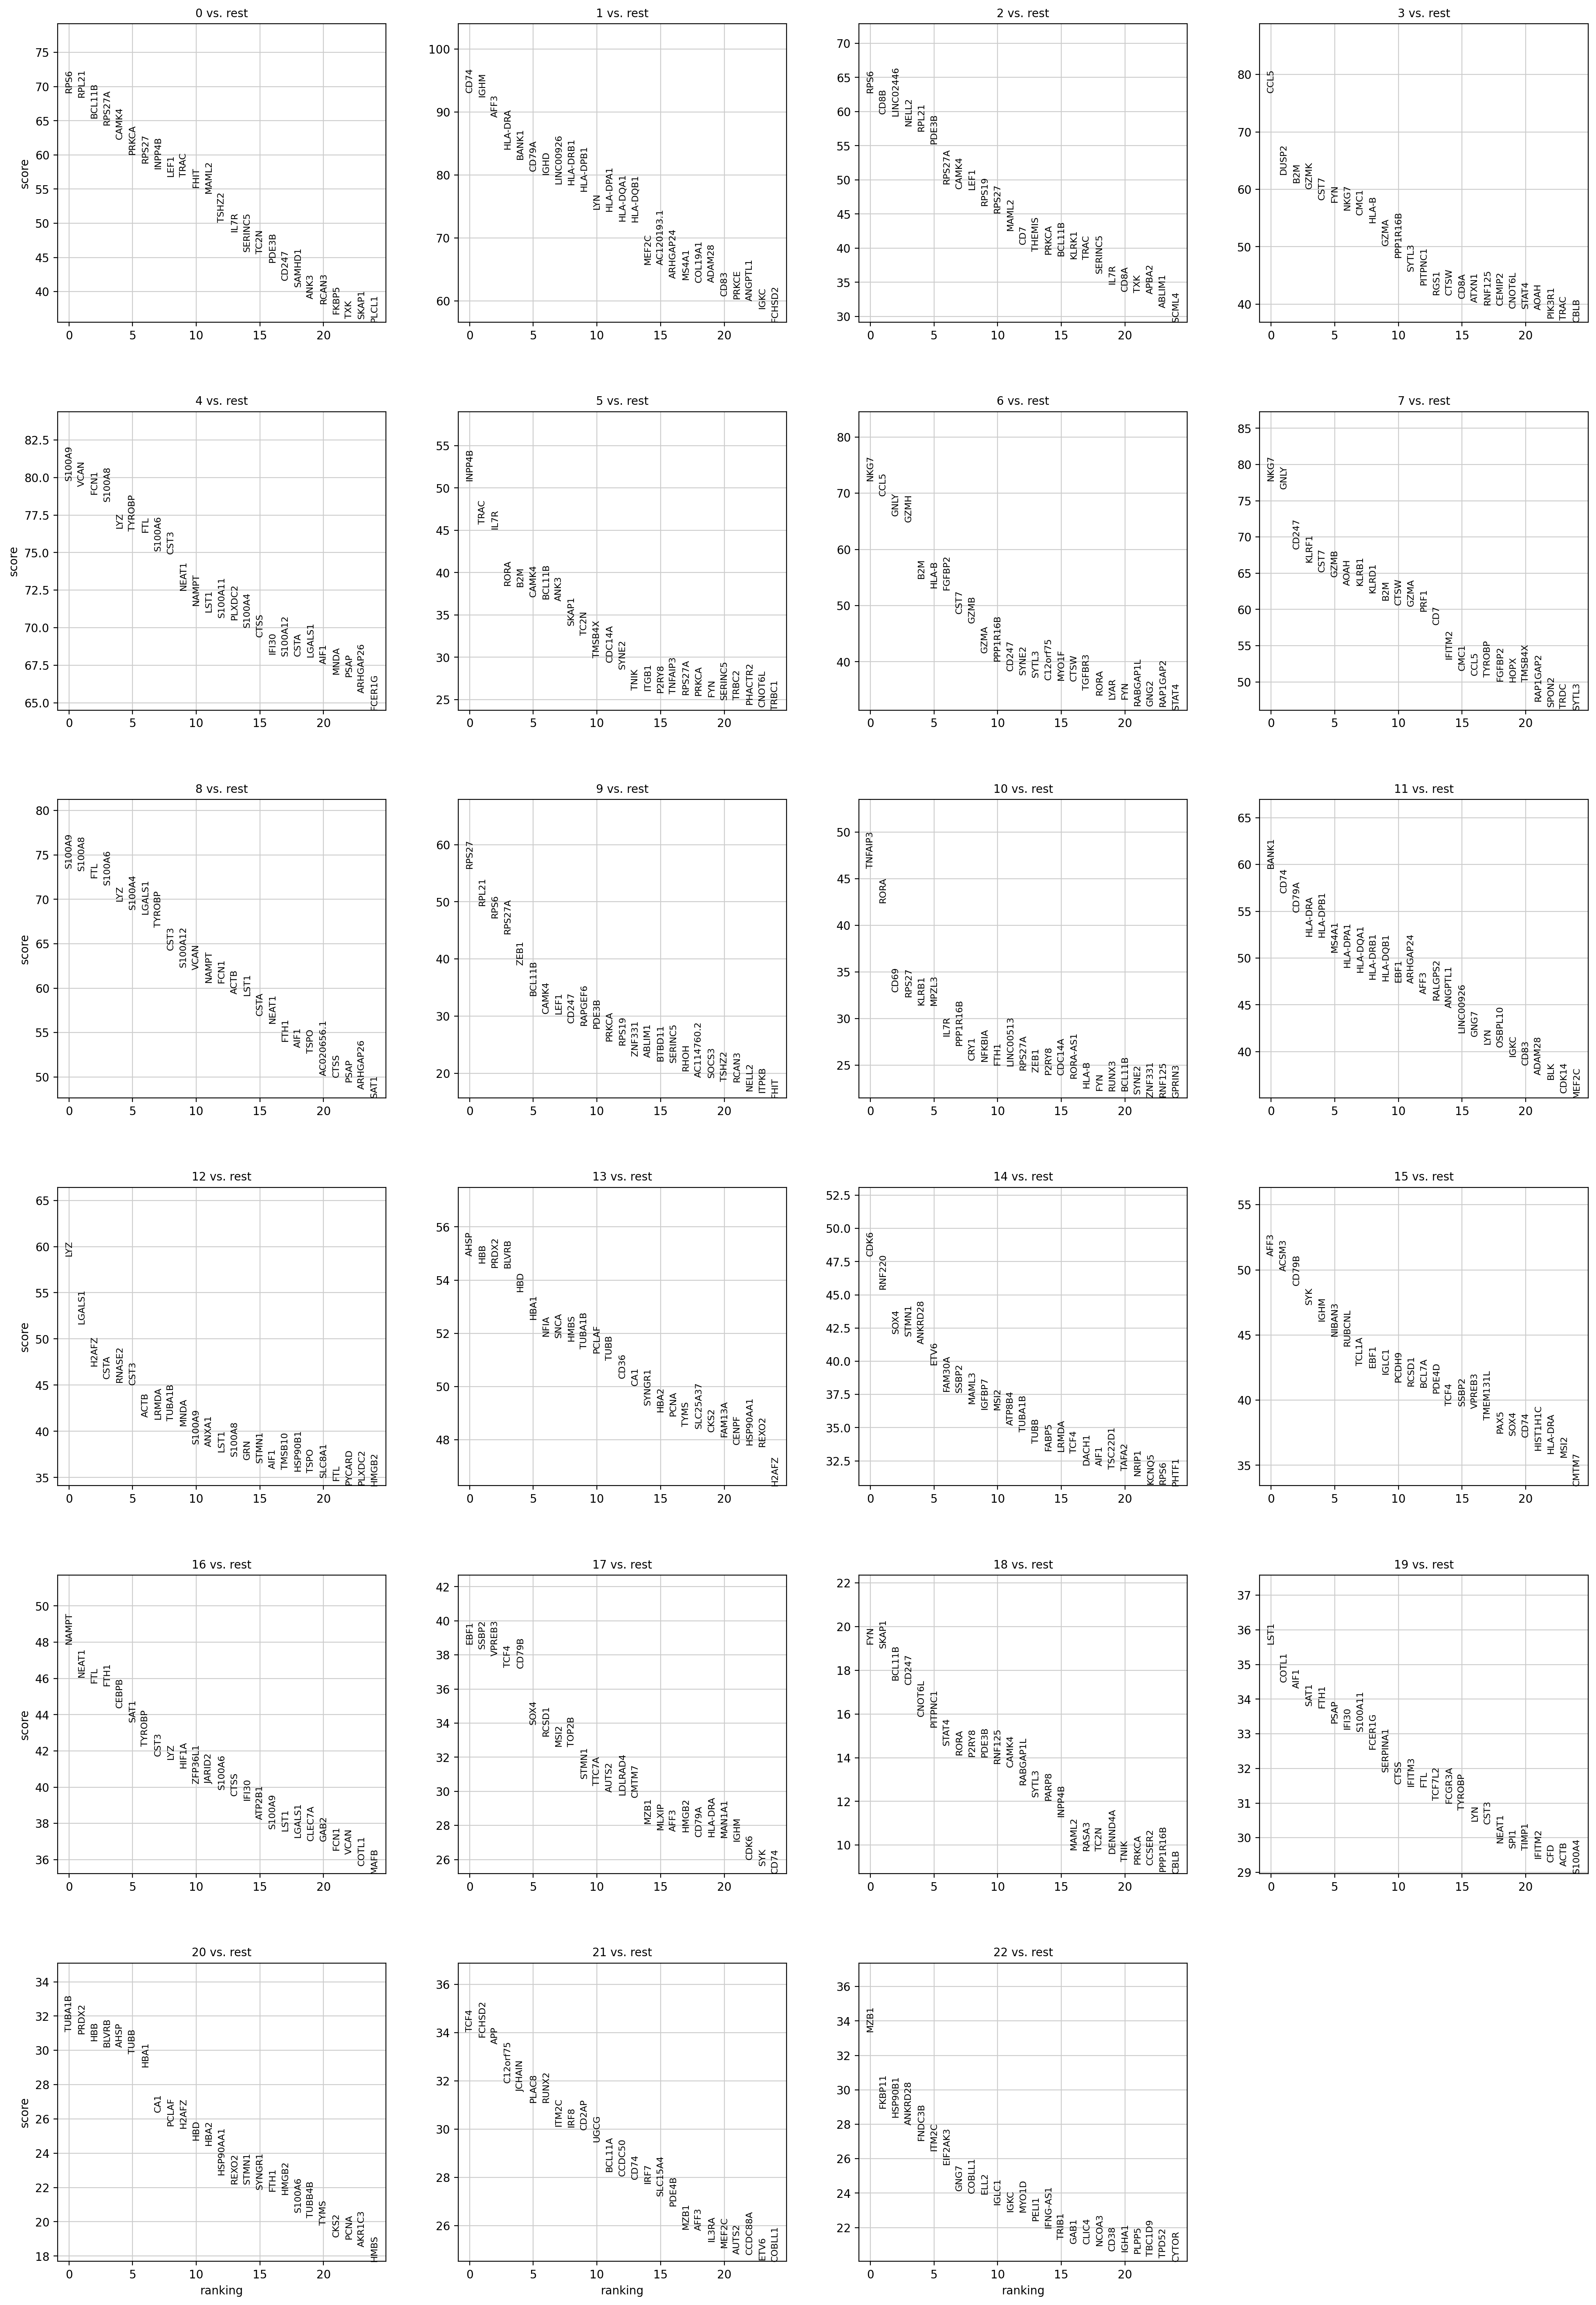

In [174]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key="wilcoxon")

In [175]:
#The suggested function from the provided tutorial does not work as expected, 
#so a dataframe was constructed of the top genes using the following text#

top_genes=[]
tg_rows = []
for i in range(leidennum):

#    print(f"Top 5 genes in Cluster {str(i)}")
#    print(sc.get.rank_genes_groups_df(adata, group=str(i), key='wilcoxon').names[0:5])
    top_genes.append(sc.get.rank_genes_groups_df(adata, group=str(i), key='wilcoxon').names[0:10])
    tg_rows.append(str(i))

df = pd.DataFrame(top_genes)
df['cluster'] = tg_rows
df = df.set_index('cluster')
df.T

#Cluster across the top, top 10 genes listed in descending order by score

cluster       0          1          2      3       4       5       6      7  \
0          RPS6       CD74       RPS6   CCL5  S100A9  INPP4B    NKG7   NKG7   
1         RPL21       IGHM       CD8B  DUSP2    VCAN    TRAC    CCL5   GNLY   
2        BCL11B       AFF3  LINC02446    B2M    FCN1    IL7R    GNLY  CD247   
3        RPS27A    HLA-DRA      NELL2   GZMK  S100A8    RORA    GZMH  KLRF1   
4         CAMK4      BANK1      RPL21   CST7     LYZ     B2M     B2M   CST7   
5         PRKCA      CD79A      PDE3B    FYN  TYROBP   CAMK4   HLA-B   GZMB   
6         RPS27       IGHD     RPS27A   NKG7     FTL  BCL11B  FGFBP2   AOAH   
7        INPP4B  LINC00926      CAMK4   CMC1  S100A6    ANK3    CST7  KLRB1   
8          LEF1   HLA-DRB1       LEF1  HLA-B    CST3   SKAP1    GZMB  KLRD1   
9          TRAC   HLA-DPB1      RPS19   GZMA   NEAT1    TC2N    GZMA    B2M   

cluster        8        9  ...      13       14      15      16      17  \
0         S100A9    RPS27  ...    AHSP     CDK6    AFF3   NAMPT    EBF1   
1         S100A8    RPL21  ...     HBB   RNF220   ACSM3   NEAT1   SSBP2   
2            FTL     RPS6  ...   PRDX2     SOX4   CD79B     FTL  VPREB3   
3         S100A6   RPS27A  ...   BLVRB    STMN1     SYK    FTH1    TCF4   
4            LYZ     ZEB1  ...     HBD  ANKRD28    IGHM   CEBPB   CD79B   
5         S100A4   BCL11B  ...    HBA1     ETV6  NIBAN3    SAT1    SOX4   
6         LGALS1    CAMK4  ...    NFIA   FAM30A  RUBCNL  TYROBP   RCSD1   
7         TYROBP     LEF1  ...    SNCA    SSBP2   TCL1A    CST3    MSI2   
8           CST3    CD247  ...    HMBS    MAML3    EBF1     LYZ   TOP2B   
9        S100A12  RAPGEF6  ...  TUBA1B   IGFBP7   IGLC1   HIF1A   STMN1   

cluster       18        19      20        21       22  
0            FYN      LST1  TUBA1B      TCF4     MZB1  
1          SKAP1     COTL1   PRDX2    FCHSD2   FKBP11  
2         BCL11B      AIF1     HBB       APP  HSP90B1  
3          CD247      SAT1   BLVRB  C12orf75  ANKRD28  
4         CNOT6L      FTH1    AHSP    JCHAIN   FNDC3B  
5        PITPNC1      PSAP    TUBB     PLAC8    ITM2C  
6          STAT4     IFI30    HBA1     RUNX2  EIF2AK3  
7           RORA   S100A11     CA1     ITM2C     GNG7  
8          P2RY8    FCER1G   PCLAF      IRF8   COBLL1  
9          PDE3B  SERPINA1   H2AFZ     CD2AP     ELL2  

[10 rows x 23 columns]

In [ ]:
df.T.to_csv('top_genes_by_cluster.csv',index=False)

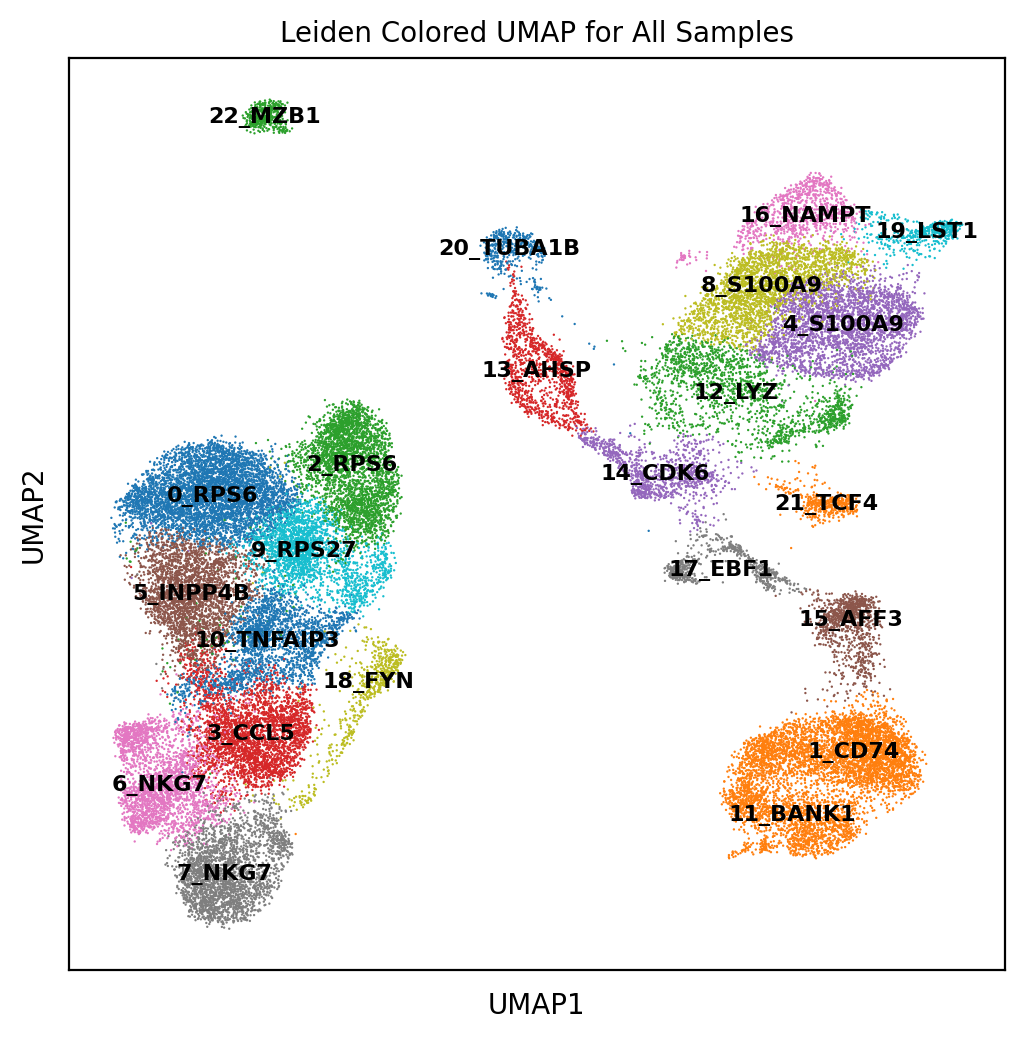

In [186]:
#Rename cluster based on top gene marker

new_cluster_names=df.index.astype(str)+'_'+df[0]
#new_cluster_names = df[0] 
new_cluster_names
adata.rename_categories('leiden', new_cluster_names)
#sc.pl.umap(adata, color=['leiden'],legend_loc='on data')

sc.pl.umap(adata, color=['leiden'],legend_loc='on data',
show=True, palette=sns.color_palette("tab10", n_colors=25),
    legend_fontsize=8, frameon=True, title='Leiden Colored UMAP for All Samples')


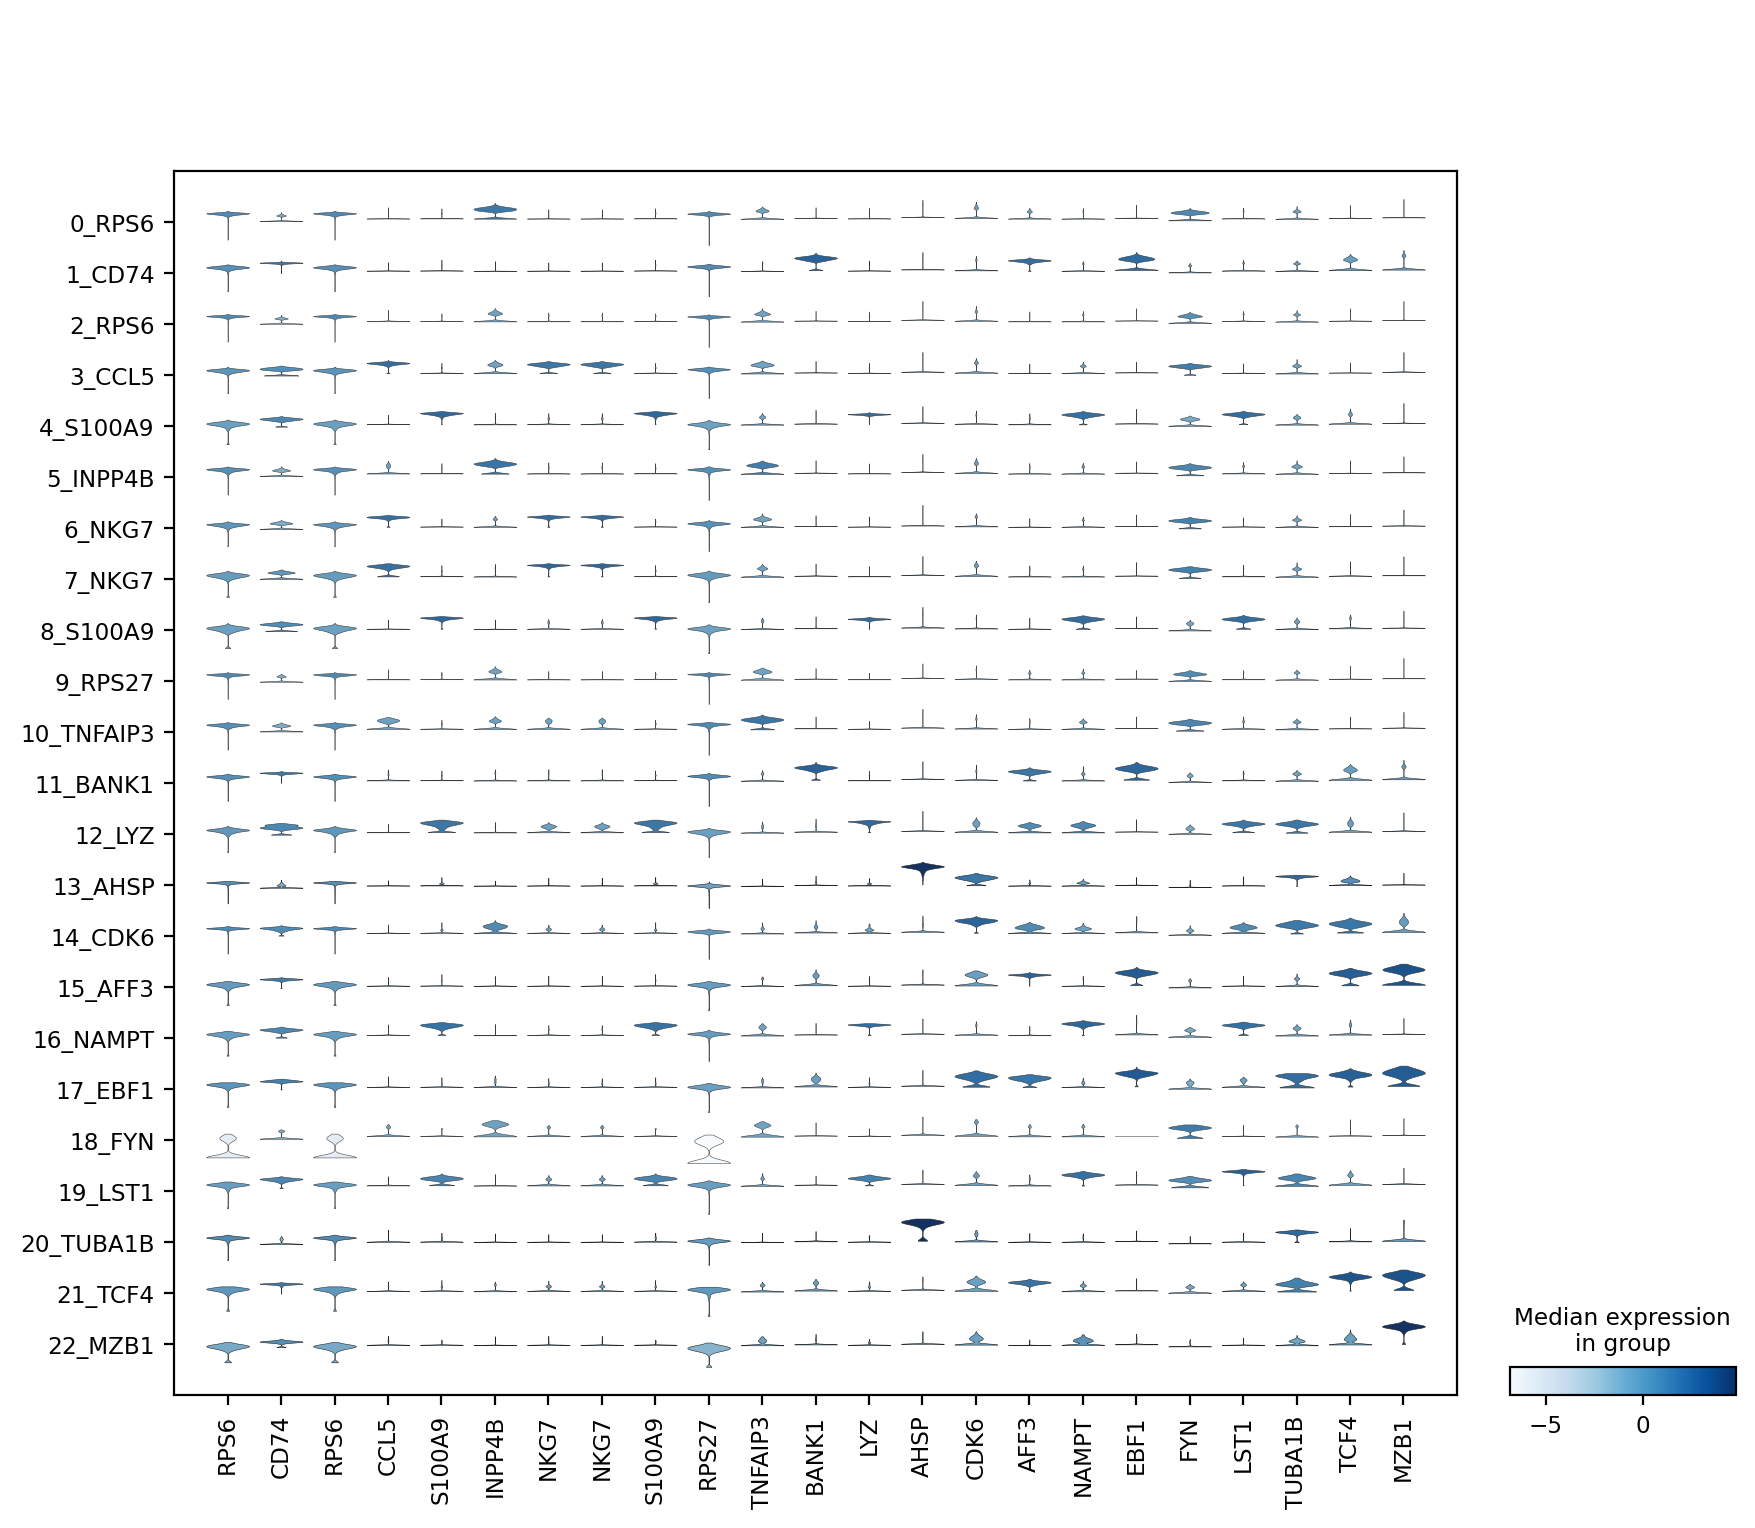

In [ ]:
ax = sc.pl.stacked_violin(adata, df[0], groupby='leiden', rotation=90)

In [178]:
#!mkdir -p results

results_file = 'results/combined_MantonBM.h5ad'
adata.write(results_file)

In [183]:
#!mkdir -p results

print("Outputting count matrixfiles for each sample to results/")

for i in range(len(samplenames)):
    
    samplename = list(set(adata[adata.obs['batch'] == str(i), :].obs['sample']))[0]
    results_file = 'results/' + samplename + 'count_matrix.h5ad'
    adata[adata.obs['batch'] == str(i), :].write(results_file)
    

Outputting count matrixfiles for each sample to results/


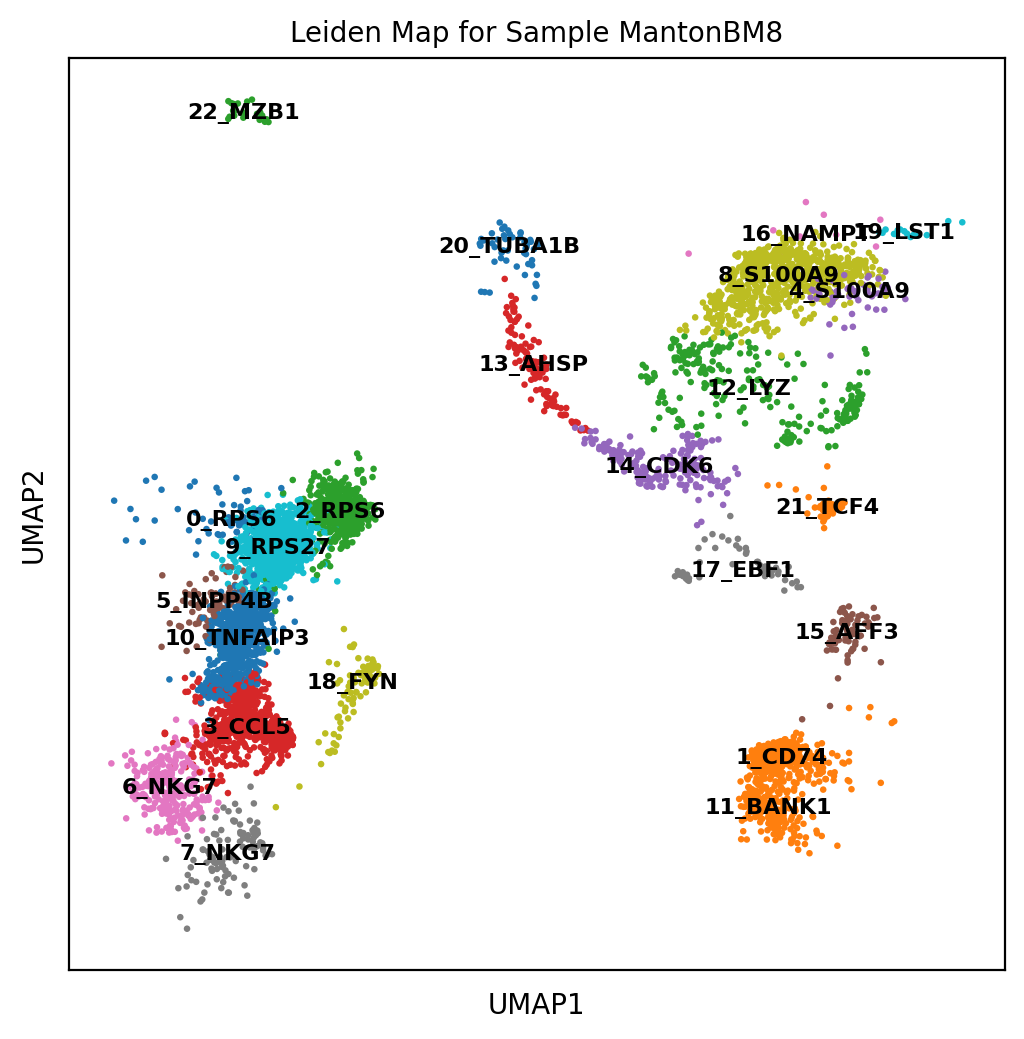

In [181]:

new_cluster_names=df.index.astype(str)+'_'+ df[0]
#new_cluster_names = df[0] 
new_cluster_names
adata.rename_categories('leiden', new_cluster_names)



sc.pl.umap(adata[adata.obs['batch'] == str(i) , :], color=['leiden'],legend_loc='on data',
show=True, palette=sns.color_palette("tab10", n_colors=25),
    legend_fontsize=8, frameon=True, title='Leiden Map for Sample ' + samplename  )




In [182]:
print("Outputting sample figures to figures/umapfigurs")

sc.settings.figdir = 'figures'
#!mkdir -p figures/umapfigures

for i in range(len(samplenames)):
    
    samplename = list(set(adata[adata.obs['batch'] == str(i), :].obs['sample']))[0]
    sc.pl.umap(adata[adata.obs['batch'] == str(i) , :], color=['leiden'],legend_loc='on data',
show=False, palette=sns.color_palette("tab10", n_colors=25),
    legend_fontsize=8, frameon=True, title='Leiden Map for Sample ' + samplename,
    save=(str(sc.settings.figdir) + '/' + samplename + '_Leiden_UMAP.png'))



Outputting sample figures to figures/umapfigurs
